# TinyML Autoencoder for ToyADMOS

Start by getting the data into the notebook. We will focus on the first case of toy car example, and use a subset of that dataset to train an autoencoder.

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import os
import librosa
import librosa.display
import matplotlib.pyplot as plt
import IPython.display as ipd

In [2]:
training_path = "/Users/emjn/Documents/DTU/Datasets/ToyConveyor/case1/NormalSound_IND/"
test_path = "/Users/emjn/Documents/DTU/Datasets/ToyConveyor/case1/AnomalousSound_IND/"

# Get the file paths for the sound files in the training and test path
training_files_path = tf.io.gfile.glob(training_path + "*ch1*.wav")
test_files_path = tf.io.gfile.glob(test_path + "*ch1*.wav")

# Let us reduce the amount of training and test samples for the moment
training_files_path = training_files_path[:1000]
test_files_path = test_files_path[:1000]

print(len(training_files_path))
print(training_files_path[0])

1000
/Users/emjn/Documents/DTU/Datasets/ToyConveyor/case1/NormalSound_IND/2100011061_ToyConveyor_case1_normal_IND_ch1_1061.wav


In [ ]:
training_audio = []
test_audio = []

_, sr = librosa.load(training_files_path[0])

for audio_file in training_files_path:
    sample, _ = librosa.load(audio_file)
    training_audio.append(sample)
    
for audio_file in test_files_path:
    sample, _ = librosa.load(audio_file)
    test_audio.append(sample)
    

Now that we have the audio loaded into memory, we create spectrograms based on the audio.

In [ ]:
FRAME_SIZE = 2048
HOP_SIZE = 512

In [ ]:
def apply_stft(audio_sample):
    stft = librosa.stft(audio_sample, n_fft=FRAME_SIZE, hop_length=HOP_SIZE)
    magnitude = np.abs(stft) ** 2
    return librosa.power_to_db(magnitude)

In [ ]:
training_magnitudes = []
test_magnitudes = []

for audio in training_audio:
    training_magnitudes.append(apply_stft(audio))
for audio in test_audio:
    test_magnitudes.append(apply_stft(audio))
    
training_magnitudes = np.array(training_magnitudes)
test_magnitudes = np.array(test_magnitudes)

Let us visualize a spectrogram of one of the sound files

In [ ]:
plt.figure(figsize=(25,10))
librosa.display.specshow(training_magnitudes[2], sr=sr, hop_length=HOP_SIZE, x_axis="time", y_axis="log")
plt.colorbar(format="%+2.f")

## Defining the model
Having generated the spectrograms we now need to preprocess the them to be suitable for the network. 

In [ ]:
training_magnitudes.shape


We need to add a new dimension to the datasets to be able to work with tensorflows convolutions that expect dimensions that would normally be present in an image (dataset_dimension, x, y, channels)

In [ ]:
training_magnitudes_4D = training_magnitudes[..., tf.newaxis]
test_magnitudes_4D = test_magnitudes[..., tf.newaxis]

# We pad the spectrograms to multiples of 4 to make max pooling and upsampling result in the same shape
x_train = tf.keras.layers.ZeroPadding2D(padding=((3,0),(1,0)))(training_magnitudes_4D)
x_test = tf.keras.layers.ZeroPadding2D(padding=((3,0),(1,0)))(test_magnitudes_4D)

x_train.shape

As it can be seen on the spectrogram plotted above, the current magnitudes range from about +35 to -45. It is problematic that the values include negative numbers as it will not be possible to reconstruct these using the ReLU activation function. Furthermore neural networks work the best in values ranging from 0-1.

Therefore we apply a shift and a scale to keep the magnitudes of the spectrograms inside this range.

In [ ]:
# Getting the min and max value to compute the shift and scale
min_value = tf.reduce_min(x_train)
max_value = tf.reduce_max(x_train)

# Apply shift
x_train = tf.math.subtract(x_train, min_value)
x_test = tf.math.subtract(x_test, min_value)

# Apply scale

x_train = x_train / max_value
x_test = x_test / max_value

## Defining the model
We now define an autoencoder to take the preprocessed spectrograms as input.

In [ ]:
encoder = tf.keras.models.Sequential()

encoder.add(tf.keras.layers.Conv2D(32, 3, padding="same",
                                   activation="relu", input_shape=x_train.shape[1:]))
encoder.add(tf.keras.layers.MaxPooling2D())

encoder.add(tf.keras.layers.Conv2D(64, 3, padding="same", activation="relu"))
encoder.add(tf.keras.layers.MaxPooling2D())

encoder.summary()

In [ ]:
decoder = tf.keras.models.Sequential()

decoder.add(tf.keras.layers.Conv2D(32, 3, padding="same", activation="relu", input_shape=encoder.output.shape[1:]))
decoder.add(tf.keras.layers.UpSampling2D())

decoder.add(tf.keras.layers.Conv2D(1, 3, padding="same", activation="relu", input_shape=encoder.output.shape[1:]))
decoder.add(tf.keras.layers.UpSampling2D())

decoder.summary()

In [ ]:
conv_autoencoder = tf.keras.Model(inputs=encoder.input, outputs=decoder(encoder.outputs))

In [ ]:
conv_autoencoder.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.MeanSquaredError())

In [ ]:
history = conv_autoencoder.fit(x_train, x_train, batch_size=64, epochs=10)

In [21]:
plt.plot(history.history["loss"], label="Training Loss")

NameError: name 'history' is not defined

In [73]:
reconstructions = conv_autoencoder.predict(x_train)

In [74]:
squeezed_reconstructions = tf.squeeze(reconstructions)
squeezed_reconstructions.shape

TensorShape([10, 1028, 432])

To get back to the original spectrogram scale we shift and scale the reconstructed spectrograms.

In [75]:
scaled_reconstructions = squeezed_reconstructions * max_value

shifted_reconstructions = tf.math.add(scaled_reconstructions, min_value)

### An original spectrogram

In [82]:
# Which spectrogram to visualize
spec_number=8

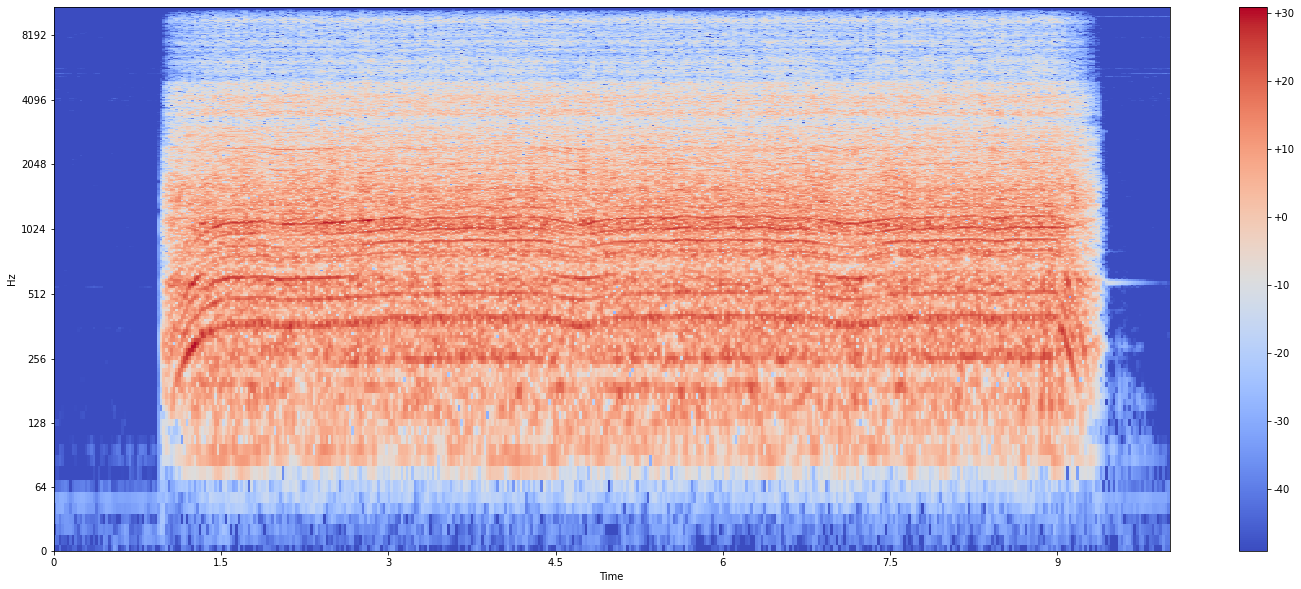

In [83]:
plt.figure(figsize=(25,10))
librosa.display.specshow(training_magnitudes[spec_number], sr=sr, hop_length=HOP_SIZE, x_axis="time", y_axis="log")
plt.colorbar(format="%+2.f")

### The reconstructed image
There seems to be an issue with the autoencoder not generating negative numbers!

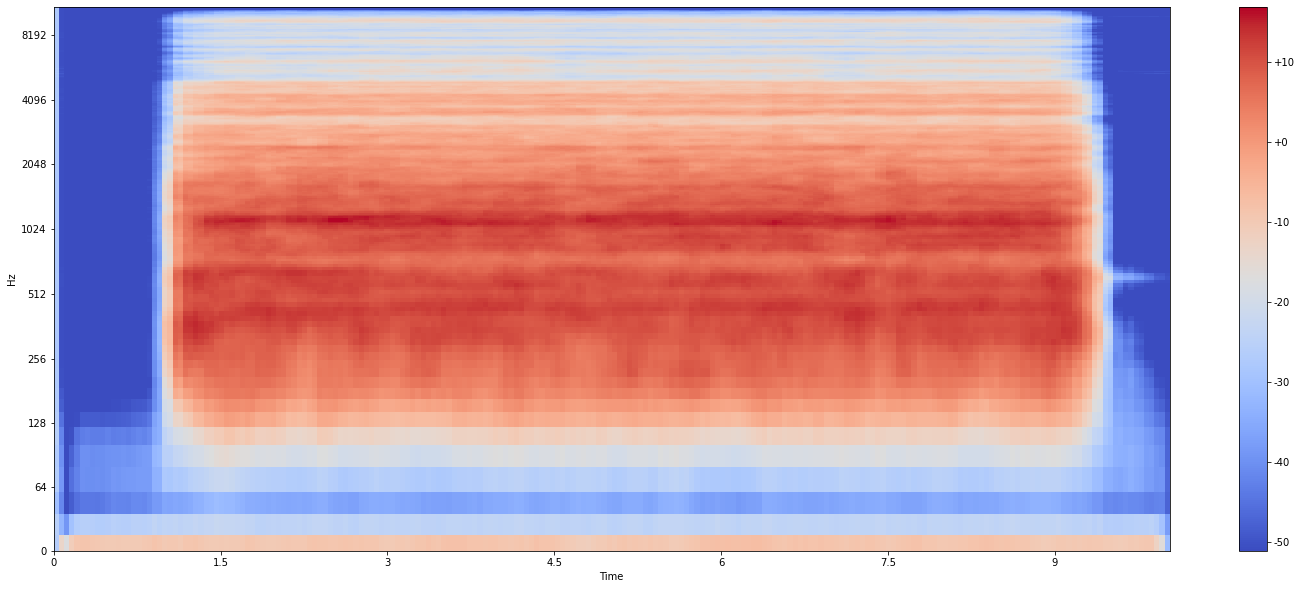

In [84]:
plt.figure(figsize=(25,10))
librosa.display.specshow(shifted_reconstructions[spec_number].numpy(), sr=sr, hop_length=HOP_SIZE, x_axis="time", y_axis="log")
plt.colorbar(format="%+2.f")

## We now have to define a treshold for when to reject a sample as normal

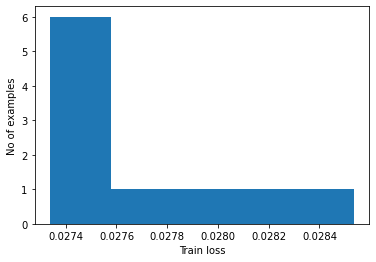

In [117]:
normal_reconstructions = reconstructions

# I implement a for loop to get the mean squared error for every prediction.
# This should also be possible to do with reduction types over a dataset.
# https://www.tensorflow.org/api_docs/python/tf/keras/losses/MeanSquaredError
mse = tf.keras.losses.MeanSquaredError(reduction=tf.keras.losses.Reduction.AUTO)

normal_losses = []
for i in range(len(x_train)):
    normal_losses.append(mse(normal_reconstructions[i], x_train[i]))

plt.hist(tf.convert_to_tensor(normal_losses)[None,:], bins=10)
plt.xlabel("Train loss")
plt.ylabel("No of examples")
plt.show()

It seems that the loss of normal samples are around 0.028. Lets try to use the test set to see if we see higher reconstruction errors

In [ ]:
abnormal_reconstructions = conv_autoencoder.predict(x_text)

abnormal_losses = []
for i in range(len(x_test)):
    abnormal_losses.append(mse(abnormal_reconstructions[i], x_test[i]))

plt.hist(tf.convert_to_tensor(normal_losses)[None,:], bins=10)
plt.xlabel("Train loss")
plt.ylabel("No of examples")
plt.show()

In [68]:
normal_reconstructions.shape

TensorShape([10, 1028, 432, 1])

In [113]:
x_train.shape

TensorShape([10, 1028, 432, 1])

In [70]:
training_magnitudes.shape

(10, 1025, 431)

In [114]:
tf.convert_to_tensor(normal_losses)

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([0.02733972, 0.02739469, 0.02853668, 0.02760541, 0.02733729,
       0.02783307, 0.02743285, 0.02735239, 0.02752652, 0.02819567],
      dtype=float32)>